# The Preface

In [39]:
%load_ext autoreload
%autoreload 2
import warnings
import requests

import data_loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

import seaborn as sns
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.neighbors import kneighbors_graph

import networkx as nx
import pickle
import operator

from scipy.sparse.linalg import eigs

import plot
import util

from functools import reduce 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
votes = data_loading.votes()
votes.head(1)

CouncillorId,15,21,26,28,61,74,76,91,94,97,...,4224,4225,4226,4227,4228,4229,4230,4232,4234,4236
VoteId,,,,,,,,,,,,,,,,,,,,,
20000431-3027,1,-1,3,1,-1,-1,-1,1,3,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


### Members

In [41]:
members = data_loading.members()
members.head(1)

,Legislative,FullName,CouncillorId,PartyAbbreviation,SimplePartyAbbreviation,SimplePartyId,Active,BirthPlace_Canton,BirthPlace_City,CantonAbbreviation,...,DateOfDeath,FirstName,GenderAsString,Image,LastName,Mandates,MaritalStatusText,ParlGroupAbbreviation,ParlGroupName,PartyName
0,0.0,Abate Fabio,801,PLR,PLR,3.0,False,Tessin,Locarno,TI,...,NaN,Fabio,m,https://www.parlament.ch/sitecollectionimages/...,Abate,Incarichi esecutivi presso il comune di Locarn...,NaN,RL,Groupe radical-libéral,Parti radical-démocratique suisse


The `members` dataframe contains background information of all members of the three swiss councils in the period from 2007 to 2019.

### Full Votes

In [42]:
full_votes = data_loading.full_votes()
with pd.option_context("display.max_columns", None):
    display(full_votes.head(1))

,VoteId,Legislative,FullName,PartyAbbreviation,SimplePartyAbbreviation,SimplePartyId,CouncillorId,AffairShortId,AffairTitle,VoteRegistrationNumber,VoteDate,VoteMeaningYes,VoteMeaningNo,DivisionText,VoteSubmissionText,VoteFilteredYes,VoteFilteredNo,VoteFilteredAbstain,VoteFilteredNotParticipated,VoteFilteredExcused,VoteFilteredPresident,CouncillorYes,CouncillorNo,CouncillorAbstain,CouncillorNotParticipated,CouncillorExcused,CouncillorPresident,Active,BirthPlace_Canton,BirthPlace_City,CantonAbbreviation,CantonName,Citizenship,CouncilName,DateJoining,DateLeaving,DateOfBirth,DateOfDeath,FirstName,GenderAsString,Image,LastName,Mandates,MaritalStatusText,ParlGroupAbbreviation,ParlGroupName,PartyName
0,20070464-248,0.0,Marra Ada,PSS,PSS,2.0,3923,20070464,Prorogation de la loi fédérale sur l'adaptatio...,248,2007-12-21 09:50:38+00:00,,,Ja,Vote final,196,1,1,1,0,1,1,0,0,0,0,0,False,Vaud,Lausanne,VD,Vaud,Paudex (VD),Conseil national,2007-12-03,2011-12-04,1973-03-10,NaN,Ada,f,https://www.parlament.ch/sitecollectionimages/...,Marra,Législatif cantonal: depuis décembre 2004 jusq...,NaN,S,Groupe socialiste,Parti socialiste suisse


The `full_votes` dataframe contains all votes in the national council between 2007 and 2019. It was joined with the members dataframe and contains also all background information for the respective councillors at that time. Note that the background information on a councillor changes over time as they might, for example, change party. The dataframe contains information for about 13500 votes (13500 * 200 rows in total as the national council has 200 members).

In [43]:
ncm_legislature = util.split_legislative(data_loading.national_council_members())

In [44]:
legislature = data_loading.votes_legislative()

def plot_by_legislature(plot_fctn, vals):
    for i, v in enumerate(vals):
        plot_fctn(v)
        plt.title('Legislature ' + str(i+1))
        plt.show()

# 1. Politician Representations
In the following section, we create different representations for the politicians. In particular, we reduce their voting behavior down to its principal components, explore the manifold of politicians using TSNE and create a nearest-neighbor graph of politicians. We will then reuse the different representations of politicians in order to validate the results of our analysis.

### Missing Values
Impute missing values with the mean along the rows. Reasoning: If a parlamentarian didn't participate in the vote, we want him to be as neutral as possible, such that he isn't defined by votes he didn't participate in.

In [45]:
def yesno_imputed(leg):
    """
    Outputs df with 0 for votes 'no', 1 for votes 'yes' and 
    mean imputation for all other votes.
    """
    yesno = leg.copy()
    yesno[yesno>1] = np.NaN
    yesno[yesno<0] = np.NaN
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    return imp.fit_transform(yesno.T).T

In [46]:
yesno_imp = [yesno_imputed(leg) for leg in legislature]

## 1.1 Global PCA
We start off by reducing the politician votes to its principal components using principal component analysis (PCA) of the entire dataset. 

In [47]:
def do_pca(data, explained_var=.75, return_fits=True):
    """
    Rescales variables to have mean zero, then performs PCA.
    
    Parameters
    ----------
    data:
        Data to transform. Rows are observations, columns are features
    explained_var:
        Retains enough principal components to explain "explained_var" percent
        of the total variance
    return_fits:
        If true, returns the rescale fit and the pca fit together with the principal components.
        Otherwise returns only principal components.
    """
    
    # Fit scaler and PCA
    scalefit = StandardScaler(with_std=False).fit(data)
    scaled = scalefit.transform(data)
    pcafit = PCA().fit(scaled)
    
    # Get nb pcs to retain
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    nb_retain = np.where(expl_var>.75)[0][0]
    
    # Project onto PCs
    pc = pcafit.transform(scaled)[:,:nb_retain]
    
    if return_fits:
        return pc, scalefit, pcafit
    else:
        return pc

pc, scalefit, pcafit = zip(*[do_pca(yn.T) for yn in yesno_imp])

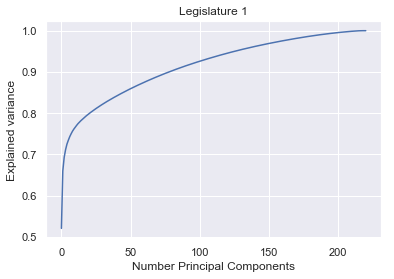

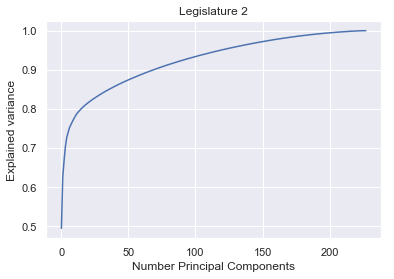

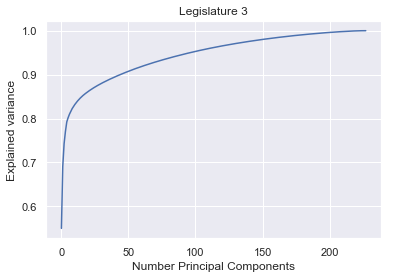

In [48]:
def explained_variance_plot(pcafit):
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    plt.plot(expl_var)
    plt.ylabel("Explained variance")
    plt.xlabel("Number Principal Components")
        
plot_by_legislature(explained_variance_plot, pcafit)
#plt.show()

Very few principal components seem to explain 75% of the data variance already, for all legislatures. We thus retain only those principal components for the future analysis.

#### Validation of PCA

*Vote Importance Score*<br>
From the PCA, we can construct an importance score for every individual vote: We do so by determining how much each vote contributes to the most important principal components. A high score means that a vote is very important for determining the politician's general location in the reduced space. We can thus validate the quality of our PCA by looking at the most- and least important votes and determine whether they make sense from a politological point of view.

In [49]:
def vote_importance_score(pc, pcafit):
    """
    Determines vote importance as the summed contribution of the vote to the retained 
    principal components.
    """
    nb_retain = pc.shape[1]
    return np.abs(pcafit.components_[:nb_retain,:]).sum(axis=0)

vote_importance = [vote_importance_score(x, y) for x,y in zip(pc, pcafit)]

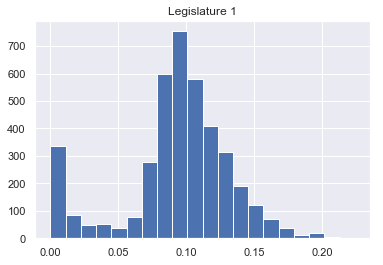

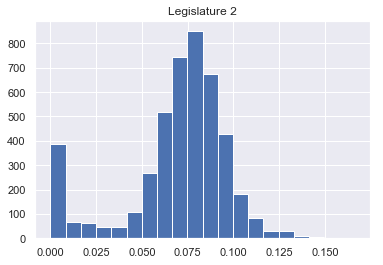

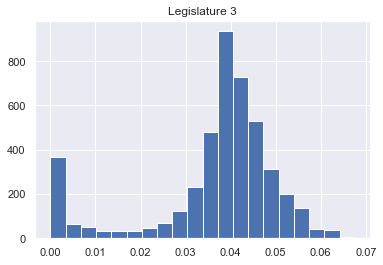

In [50]:
plot_by_legislature(lambda x: plt.hist(x, bins=20), vote_importance)


> TODO: Look at the outliers in both directions, see whether they make sense. If yes: Good pca, if not: Bad PCA

*Interpretation of the principal direction*<br>
Another way to validate the PCA is to see whether we can find an interpretation of the principal directions. To this effect, we correlate the principal component scores of the politicians with other attributes known about them, such as their age, gender, number of votes they participated in, etc.

> Moreover it would be interesting to correlate the principal components with other interesting variables about the politicians, such as gender, age, legislature or language, to see whether our principal components have a real-life interpretation.

## 1.2 Non-linear Embedding in 2D with t-SNE

Using the principal component analysis, we embedded the data into a lower-dimensional space using a linear transformation. In order to visualize the data, we need to further reduce it to two dimensions. For this we rely on the non-linear two-dimensional embedding obtained with the t-distributed stochastic neighborhood embedding (t-SNE) algorithm. This algorithm reduces similar politicians to nearby points, whereas dissimilar politicians are far from each other. By doing so it can reveal clusters when they are present in the data. 

In [51]:
def do_tsne(pc):
    return TSNE(random_state=42).fit_transform(pc)

tsne = [do_tsne(x) for x in pc]

In [52]:
plot.nodes(tsne[0], info_df=ncm_legislature[0], cluster_column='SimplePartyAbbreviation')

:Nodes   [x,y,index]   (Legislative,FullName,CouncillorId,PartyAbbreviation,SimplePartyAbbreviation,SimplePartyId,Active,BirthPlace_Canton,BirthPlace_City,CantonAbbreviation,CantonName,Citizenship,CouncilName,DateJoining,DateLeaving,DateOfBirth,DateOfDeath,FirstName,GenderAsString,Image,LastName,Mandates,MaritalStatusText,ParlGroupAbbreviation,ParlGroupName,PartyName)

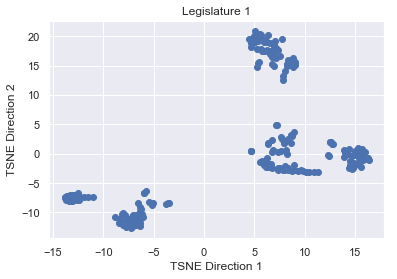

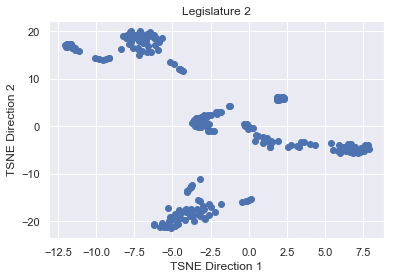

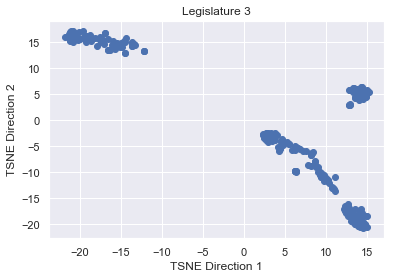

In [53]:
def plot_tsne(tsne):
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.xlabel("TSNE Direction 1")
    plt.ylabel("TSNE Direction 2")

plot_by_legislature(plot_tsne, tsne)


The TSNE plot indicates that certain politicians group together, which manifests in several clusters forming. However, note that the results of the TSNE should be taken with a grain of salt, since its complexity sometimes leads to unexpected results.

## 1.3 Graph Representation
A third way to represent the politicians will be in the form of an undirected graph. The graph is imputed such that every politician is connected to his k nearest neighbors in space. For technical reasons, we want the resulting graph to be connected. Moreover, we will assign as the weight between the two politicians $p_1$ and $p_2$ to be:
$\quad w_{ij} = \exp \{ \frac{1}{2\sigma^2} \|p_1 - p_2\|_2^2 \}$

In [54]:
def get_knn_graph(pc, k=10):
    """
    Obtains knn_graph, returns networkX weighted graph object.
    
    Parameters
    ----------
    pc:
        Principal components for graph imputation
    k:
        Number of nearest neighbors to consider
    """
    knn_graph = kneighbors_graph(pc, k, mode="connectivity")

    # Create networkx object
    nx_graph = nx.from_scipy_sparse_matrix(knn_graph)
    if not nx.is_connected(nx_graph):
        warnings.warn("Resulting graph is not connected, spectral embedding may give unexpected results")
    return nx_graph

knn_graph = [get_knn_graph(x, k=20) for x in pc]
knn_graph_plot_pos = [nx.spring_layout(g) for g in knn_graph]

In [55]:
import holoviews as hv

In [56]:
hv.Layout([a, b])

NameError: name 'a' is not defined

/Users/oriane/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


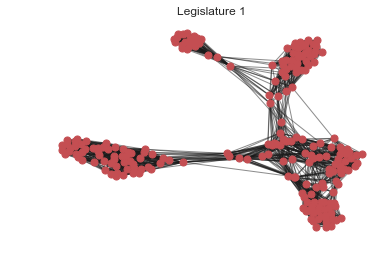

/Users/oriane/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


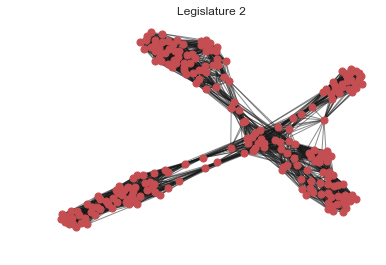

/Users/oriane/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


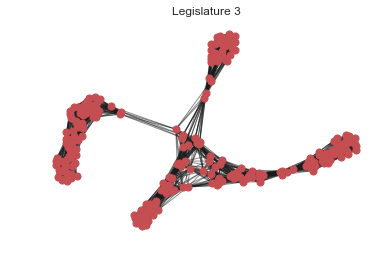

In [57]:
def draw_graph(G, pos=None):
    if pos is None:
        pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=.5)
    plt.axis('off')
    
for i, (g, p) in enumerate(zip(knn_graph, knn_graph_plot_pos)):
    #plt.figure(figsize=(16,9))
    draw_graph(g, p)
    plt.title('Legislature ' + str(i+1))
    plt.show()


**Spectral Embedding**<br>
The spectral embedding embeds the graph into a n-dimensional space. This can be used for visualizing the graph itself or for spectral clustering, as used below. 
<br><br>
Reference:
*U. Von Luxburg*, “A tutorial on spectral clustering,” *Stat. Comput., vol. 17, no. 4, pp. 395–416, 2007.*

In [58]:
def spectral_embedding(nx_graph, n=15):
    """
    Calculates spectral embedding based on normalized Laplacian matrix.
    
    Parameters
    ----------
    nx_graph:
        NetworkX graph to analyze
    n_evals:
        Number of smallest eigenvalues and corresponding eigenvectors to be computed
        
    Returns
    -------
    evals:
        Eigenvalues of spectral embedding
    evecs:
        Eigenvectors of spectral embedding
    """
    norm_L = nx.normalized_laplacian_matrix(nx_graph)
    evals, evecs = eigs(norm_L, k=n, which="SM")
    evals = np.real(evals)
    evecs = np.real(evecs)
    return evals, evecs

sp_evals, sp_evecs = zip(*[spectral_embedding(g) for g in knn_graph])

#### Validation
We validate the graph by looking at its properties.


*Node degree distribution*

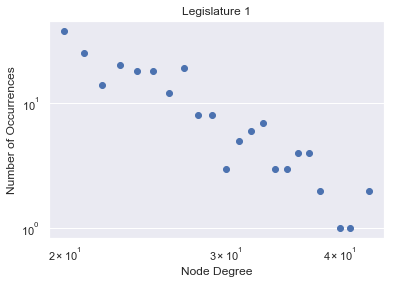

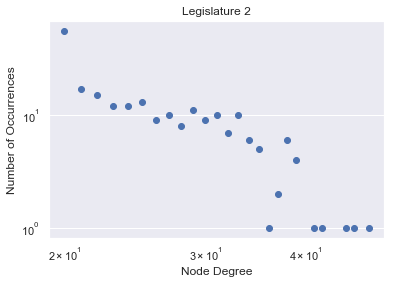

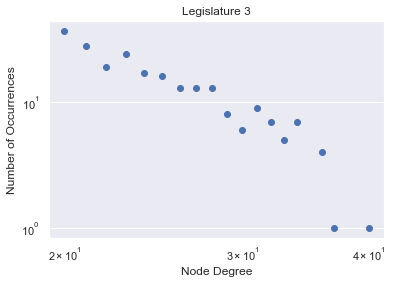

In [59]:
def plot_degree_distribution(graph):
    deg = np.array(graph.degree())[:,1]
    val, count = np.unique(deg, return_counts=True)
    plt.loglog(val, count, 'o')
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Occurrences")

plot_by_legislature(plot_degree_distribution, knn_graph)


>Todo: This isn't a power law anymore

Here, we plot the node degree distribution. We see that it is heavy-tailed, roughly follows a power law. This behavior is typical for social networks, which suggests that our graph is an adequate representation for the political landscape.

## 1.4 Saving Intermediary Results

In [60]:
with open('../generated/leg_pc.pickle', 'wb') as file:
    pickle.dump(pc, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('../generated/leg_tsne.pickle', 'wb') as file:
    pickle.dump(tsne, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('../generated/leg_graph.pickle', 'wb') as file:
    pickle.dump(knn_graph, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('../generated/leg_graph_plot_pos.pickle', 'wb') as file:
    pickle.dump(knn_graph_plot_pos, file, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Recovering Clusters

## 2.1 K-Means Clustering

We perform k-means clustering in order to cluster our politicians based on their voting behavior. We do this on the principal components calculated above, in order to avoid the curse of dimensionality.

We run k-means clustering with a range of possible number of clusters. Then, we determine the optimal number of clusters using a so-called knee-plot, which plots the within-cluster variance against the number of clusters. 

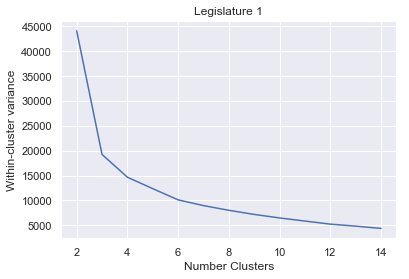

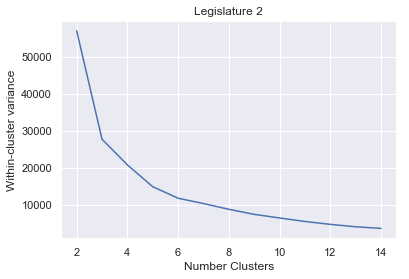

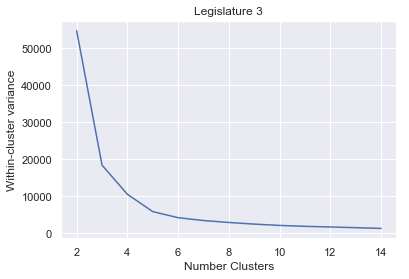

In [61]:
def inertia_plot(pc, cluster_range=np.arange(2,15)):
    kmeans_fit = []
    inertia = []
    for nc in cluster_range:
        cl = KMeans(n_clusters=nc).fit(pc)
        kmeans_fit.append(cl)
        inertia.append(cl.inertia_)
        
    plt.plot(cluster_range, inertia)
    plt.ylabel("Within-cluster variance")
    plt.xlabel("Number Clusters")

plot_by_legislature(inertia_plot, pc)

In the knee-plot, the optimal number of clusters can be determined as the "knee" of the graph. In our case, 4 clusters seem plausible for all legislatures.

In [62]:
def get_kmeans_clusters(pc, k=4):
    cl = KMeans(n_clusters=4).fit(pc)
    return cl.labels_

kmeans_cl = [get_kmeans_clusters(x) for x in pc]

## 2.2 Graph Based Clustering
In order to validate the clustering, we compare the results with graph-based clustering. For this we impute a graph of politicians as a k-nearest-neighbor graph, where we connect every politician to their k nearest neighbors in the space of the most important principal components. This allows us to perform spectral clustering on the resulting graph.

#### Spectral Clustering
From the spectral decomposition, we can obtain the number of clusters in the graph with the so-called eigengap heuristic: According to it, the number of clusters is given by the value $k$ that maximizes the difference of consecutive eigenvalues.

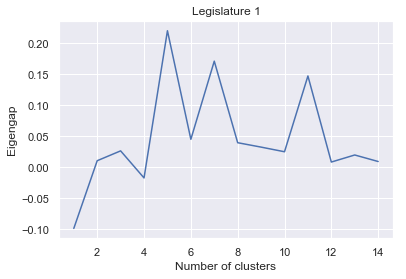

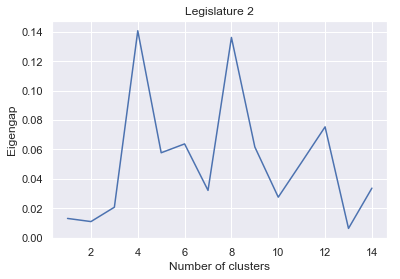

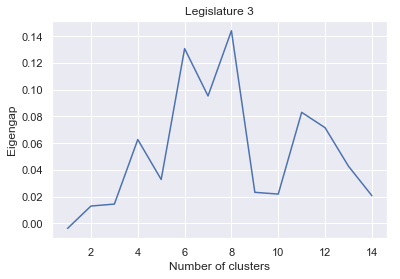

In [63]:
def plot_eigengap(evals):
    n_evals = len(evals)
    plt.plot(np.arange(1, n_evals), evals[1:] - evals[:-1])
    plt.xlabel("Number of clusters")
    plt.ylabel("Eigengap")

plot_by_legislature(plot_eigengap, sp_evals)


The plot suggests 11 clusters in the first legislature, 12 in the second and 6 or 12 in the third (we take 12 for better comparibility).

In [64]:
def spectral_clustering(evecs, k):
    red = evecs[:,:k]
    clusters = KMeans(n_clusters=k).fit_predict(red)
    return clusters

n_spec_cl = [11, 12, 12] # Number clusters for every legislature

spec_cl = [spectral_clustering(evecs, k) for evecs, k in zip(sp_evecs, n_spec_cl)]

## 2.3 Clustering Result Comparison
We now go back to our TSNE plot to visualize the different clusterings we obtained so far.

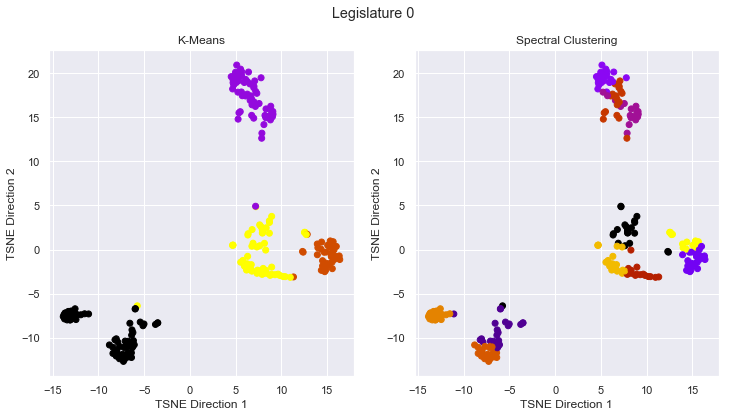

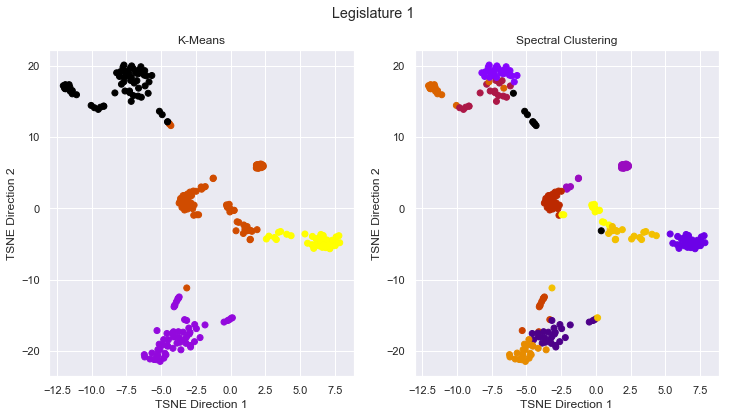

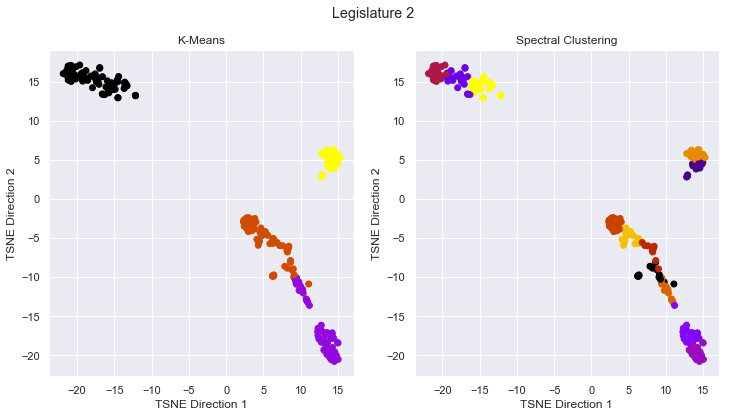

In [65]:
def visualize_clusterings(coordinates, clusters):
    plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, cmap="gnuplot")
    plt.xlabel("TSNE Direction 1")
    plt.ylabel("TSNE Direction 2")

def cluster_compare(cl1, cl2, coords, tit1="K-Means", tit2="Spectral Clustering"):
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title(tit1)
    visualize_clusterings(coords, cl1)

    plt.subplot(122)
    plt.title(tit2)
    visualize_clusterings(coords, cl2)

for i, (cl1, cl2, coords) in enumerate(zip(kmeans_cl, spec_cl, tsne)):
    cluster_compare(cl1, cl2, coords)
    plt.suptitle('Legislature ' + str(i))
    plt.show()

>TODO WHAT DO WE SEE

# 3. The Swiss Executive Power 
In Switzerland the executive branch of government consists of a council of 7 people which are chosen to roughly represent the political landscape of Switzerland. In this part we ask whether political parties are necessary to form this executive council or whether other ways could be found to choose suitable people.

## 3.1 Finding the Federal counselors
The first step is to find the politician that went on to become federal counselors and whose voting behavior is in our database. We decide here to look only at current Federal councelor based on their voting pattern from the two last legislative. The idea is to see if we could have predicted whether they would be a suitable fit for this legislative based on passed data

In [66]:
# Selecting members of the federal council that were active in the last legislative 
federal_counselor = members.loc[members["CouncilName"] == "Conseil fédéral"][['FullName','Legislative']]
federal_counselor= federal_counselor.loc[federal_counselor['Legislative']==2.0][['FullName']].drop_duplicates()
federal_counselor = federal_counselor.set_index(['FullName'])

# Finding who among them where a national concelor for the first and/or the second legislative
federal_counselor_votes = full_votes.join(federal_counselor,on=['FullName'],how="right")
federal_counselor_votes = federal_counselor_votes[["FullName","PartyAbbreviation","CouncillorId",'Legislative']]
federal_counselor_votes = federal_counselor_votes.loc[federal_counselor_votes['Legislative'].isin([0,1])]

# Seeing who is left 
print("The Federal counslors we can study are :")
federal_counselor_names = federal_counselor_votes[["FullName","PartyAbbreviation","CouncillorId"]].drop_duplicates("FullName")
federal_counselor_names= federal_counselor_names.set_index(["CouncillorId"])
federal_counselor_names.index = federal_counselor_names.index.map(int)
federal_counselor_names

The Federal counslors we can study are :


,FullName,PartyAbbreviation
CouncillorId,,
1108,Parmelin Guy,UDC
508,Schneider-Ammann Johann N.,PLR
146,Maurer Ueli,UDC


In [67]:
#Finding how many data we have for each 
numbers_votes = federal_counselor_votes.groupby(["FullName",'Legislative']).count()
numbers_votes["Count"] = numbers_votes["PartyAbbreviation"]
print("The amount of data available for our analysis is :")
numbers_votes.drop(["PartyAbbreviation","CouncillorId"],axis=1)

The amount of data available for our analysis is :


Count
FullName                   Legislative       
Maurer Ueli                0.0            480
Parmelin Guy               0.0           4027
                           1.0           4539
Schneider-Ammann Johann N. 0.0           2610

We see that our analysis will be limited by the fact that only three federal conselor's voting record are in the database. This is too few datapoint to derive some meaningful conclusion. Plus number of data per counslor is very variable and this could also be a limit to our analysis. However it is still interesting to see what conclusion can be drawn from those points. We chose here to only look at information from the first legislature as it is the only one where all there councelor are present.

In [68]:
# Creating a mapping from counslor id to their index in the numpy matrix used when doing pca. 
CouncillorId_to_idx = dict(zip(votes.T.index.map(int),range(len(votes.T))))
ids_to_CouncillorId = dict(zip(range(len(votes.T)),votes.T.index.map(int)))

In [69]:
federal_counselor = members.loc[members["CouncilName"] == "Conseil fédéral"][['FullName','Legislative']]
federal_counselor= federal_counselor.loc[federal_counselor['Legislative']==2.0][['FullName']].drop_duplicates()
federal_counselor = federal_counselor.set_index(['FullName'])

# Finding who among them where a national concelor for the first and/or the second legislative
federal_counselor_votes = full_votes.join(federal_counselor,on=['FullName'],how="right")
federal_counselor_votes = federal_counselor_votes[["FullName","PartyAbbreviation","CouncillorId",'Legislative']]

In [70]:
# Get info for the plotting
federal_counsilor_info = ncm_legislature[0].loc[ncm_legislature[0]["CouncillorId"].isin(federal_counselor_names.index.map(str))]

## 3.2 Visualizing the Executive Power 

Now let's see where those politicians are in the representation of our data we made above.

### 3.2.1 TSNE Representation

In [71]:
federal_counsilor_pos_tsne = np.asarray([tsne[0][i] for i in federal_counsilor_info.index])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
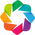

In [73]:
import holoviews as hv
hv.extension('bokeh')

In [74]:
all_points = plot.nodes(tsne[0],info_df=ncm_legislature[0],cluster_column='SimplePartyAbbreviation').opts(alpha=0.7)
fc_points = plot.nodes(federal_counsilor_pos_tsne,federal_counsilor_info)
(all_points*fc_points.options(color='pink')).relabel("TSNE of Councillors Voting Trends in '07-'11")

:Overlay
   .Nodes.I  :Nodes   [x,y,index]   (Legislative,FullName,CouncillorId,PartyAbbreviation,SimplePartyAbbreviation,SimplePartyId,Active,BirthPlace_Canton,BirthPlace_City,CantonAbbreviation,CantonName,Citizenship,CouncilName,DateJoining,DateLeaving,DateOfBirth,DateOfDeath,FirstName,GenderAsString,Image,LastName,Mandates,MaritalStatusText,ParlGroupAbbreviation,ParlGroupName,PartyName)
   .Nodes.II :Nodes   [x,y,index]   (Legislative,FullName,CouncillorId,PartyAbbreviation,SimplePartyAbbreviation,SimplePartyId,Active,BirthPlace_Canton,BirthPlace_City,CantonAbbreviation,CantonName,Citizenship,CouncilName,DateJoining,DateLeaving,DateOfBirth,DateOfDeath,FirstName,GenderAsString,Image,LastName,Mandates,MaritalStatusText,ParlGroupAbbreviation,ParlGroupName,PartyName)

>The federal councillor are in pink

It is interesting to see that none of the exemple we have seem to be very central in their party cluster. Ueli Maurer is even quite far aparte from the rest of UDC. Johann Schneider-Ammann seems also somewhat isolated. This would indicate that having a voting pattern representative of one's party isn't essential to be elected for the federal council. We can see if this results is maintained in the graph representation. 

### 3.2.2 Graph Representation

In [ ]:
federal_counsilor_pos_graph = np.asarray([knn_graph_plot_pos[0][i] for i in federal_counsilor_info.index])

In [ ]:
overall_graph = plot.graph_from_nx(knn_graph[0], node_positions=knn_graph_plot_pos[0] ,info_df=ncm_legislature[0],cluster_column='SimplePartyAbbreviation').opts(node_alpha=0.7)
federal_councillor_nodes = plot.nodes(federal_counsilor_pos_graph,federal_counsilor_info)
(overall_graph*federal_councillor_nodes.options(color='pink')).relabel("Councillors Voting Trends in '07-'11 Legislative")

>The federal councillor are in pink

Again none of the points are very central in their cluster. The observation made on the TSNE are applicable here as well. Ueli Maurer is again noticably for from the UDC. the points. It is also interesting to note that all points seems somehow well connected. It is the most visible for Johann Schneider-Ammann. It would seems like a good criteria for a exectutive represent to be a "hub" of the graph as it would mean they have a voting pattern similar to more people and therefore would be representative of more people. Let's take a closer look at the "hub" propriety of our three counselor.

### 3.2.3 Node Closeness

In [ ]:
def write_names(name,party):
        return name + " (" + party + ")"
colors = ['xkcd:highlighter green','xkcd:hot pink','xkcd:orange yellow']

In [ ]:
def plot_degree_distribution(graph,councelor_df):
    plt.figure(figsize=(20,9))
    degrees = np.array(graph.degree())[:,1]
    names = [write_names(x["FullName"], x['PartyAbbreviation']) for i,x in ncm_legislature[0].iterrows()]
    name_deg_dict = dict(zip(names,degrees))
    sorted_dict = np.asarray(sorted(name_deg_dict.items(), key=operator.itemgetter(1)))
    labels = [write_names(x["FullName"], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()]
    plt.bar(sorted_dict[:,0],sorted_dict[:,1])
    plt.xticks([name_deg_dict[l] for l in labels],labels,rotation=80)
    plt.xlabel("Councillors")
    plt.ylabel("Node Degree")
    plt.title("Node Degree per Councillor")
plot_degree_distribution(knn_graph[0],federal_counsilor_info)    

The federal councillor here were clearly not the best connected national counsillor during the '07-'11 legislature. Rationally it would seem that the more connected a point is, the more people are agreeing with it. We can make the hypothesis that a good executive power member is someone who agrees with the most members of the legislative power. This make sense if we want the law makers to be happy with the way the law is applied. Instead of mesuring the degree we could also look at the closeness of the node. This is defined as :
    
    Closeness centrality of a node u is the reciprocal of the sum of the shortest path distances from u to all n-1 other nodes.*

**Linton C. Freeman: Centrality in networks: I. Conceptual clarification. Social Networks 1:215-239, 1979. http://leonidzhukov.ru/hse/2013/socialnetworks/papers/freeman79-centrality.pdf*

In [ ]:
def plot_closeness(graph,councelor_df,selected_councelor_df,title):
    plt.figure(figsize=(20,9))
    closeness = np.array(list(map(lambda x :round(x[1], 2),nx.closeness_centrality(graph).items())))
    names = [write_names(x["FullName"], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()]
    name_close_dict = dict(zip(names,(closeness)))                      
    s = np.asarray(sorted(name_close_dict.items(), key=operator.itemgetter(1)))
    name_new_pos = {k:i for i,k in enumerate(s[:,0])}                       
    labels = [write_names(x["FullName"], x['PartyAbbreviation']) for i,x in selected_councelor_df.iterrows()]
    pos = [name_new_pos[name] for name in labels]
    plt.bar(s[:,0],s[:,1])
    plt.xticks(pos,labels,rotation=80)
    plt.xlabel("Councillors")
    plt.ylabel("Node Closeness")
    plt.title(title)
plot_closeness(knn_graph[0],ncm_legislature[0],federal_counsilor_info,"Node Closeness per Councillor")    

Even thought they aren't necessarly high degree node, some of the federal councillor are some of the nodes with the highest closeness. It does therefore seem that having a voting pattern similar to the majority is helpful when hoping to get elected on the federal council. It's important to note again that no conclusive information can be infered from the very fews data points we have access to. Here only 2 of the 3 points we have show a high closeness and might not be representative of the rest of the federal councillor. It's also important to take into consideration that the high closeness of Ueli Maurer could be due to the significantly lower amount of vote data we have for this counscillor.

### 3.2.4 Representing one's own party

Another interesting mesurment is how well these councillors are representing their own party. To mesure this we can represente each of their party in an individual graph and visualize their closeness in this context.

#### 3.2.4.1 Seeing about UDC

In [ ]:
udc_info = ncm_legislature[0].loc[ncm_legislature[0]["PartyAbbreviation"] == "UDC"]
# Making UDC graph
udc_pc = pc[0][udc_info.index]
udc_knn_graph = get_knn_graph(udc_pc, k=5) 

plot_closeness(udc_knn_graph,udc_info,federal_counsilor_info.loc[[11,92]],"UDC Closeness")    


#### 3.2.4.2 Seeing about PLR

In [ ]:
plr_info = ncm_legislature[0].loc[ncm_legislature[0]["PartyAbbreviation"] == "PLR"]
# Making UDC graph
plr_pc = pc[0][plr_info.index]
plr_knn_graph = get_knn_graph(plr_pc, k=5) 

plot_closeness(plr_knn_graph,plr_info,federal_counsilor_info.loc[[70]],"PLR Closeness")    


None of the elected councillor seem to have a voting pattern that is very representative of the polictical party. It seem that a lot of other candidates would be more better was the selection criteria on having a political stance reprensentative of one's party.

## 3.3 Picking a "Better" Executive Power

### 3.3.1 Picking the Nodes from Spectral Clusters

Following the hypothesis that a well connected individual is a good fit for a federal counselors, we can try and derive the best fit from the data. We can make the additional hypothesis that the set of 7 counselors need to cover the full spectrum of political view in the national council. We decide to focus on counselor that are active in this legislative so to have a good proposal for the votation of the next legislative. To do so we use the spectral clustering from part one to create 7 clusters and node with highest closeness from each.

In [ ]:
# Perform spectral clustering using k=7 on Eigenvectors of spectral embedding of first legislative 
spec_cl_7 = spectral_clustering(sp_evecs[0], 7)
clusters = pd.DataFrame({"Nodes":knn_graph[0].nodes(),"Clusters":spec_cl_7,"Degree":list(nx.closeness_centrality(knn_graph[0]).values())})
clusters = clusters.set_index("Clusters")
# Here we pick the node with highest closeness per cluster
inv_closeness = {v: k for k, v in nx.closeness_centrality(knn_graph[0]).items()}
max_per_clusters = clusters.groupby(["Clusters"]).apply(lambda x : max(x["Degree"]))
max_nodes = [inv_closeness[x] for x in max_per_clusters]

In [ ]:
# visualizing our pick
our_councillor = ncm_legislature[0].iloc[max_nodes]
our_councillor[["FullName","PartyAbbreviation"]]

> Several observation can already be made : 
- There is no overlapping with the actual list of federal concelor 
- The whole political spectrum is represented  


In [ ]:
from PIL import Image
from io import BytesIO
import requests
url = "https://assets.letemps.ch/sites/default/files/styles/share/public/media/2017/12/07/file6xvmqbr36s4soxt5kjm.png.jpeg?itok=UHqSuRlU"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

### 3.3.2 Graph Representation
We can see where thoses points are on the graph, and visualize them in the context of the spectral clusters that we defined

In [ ]:
# Plotting the 7 found clusters
graph = plot.graph_from_nx(knn_graph[0], node_positions=knn_graph_plot_pos[0] ).opts(node_alpha=0.7)

def plot_clusters(cluster,color,graph):
    cluster_idx = [i for i, x in enumerate(spec_cl_7 == cluster) if x]
    cluster_info = ncm_legislature[0].iloc[cluster_idx]
    cluster_pos = np.asarray([knn_graph_plot_pos[0][i] for i in cluster_idx])
    cluster_point = plot.nodes(cluster_pos,cluster_info)
    cluster_graph = cluster_point.options(color=color)
    return cluster_graph
colors = ["purple","blue","green","yellow","cyan","grey","red"]
cluster_graphs = [plot_clusters(i,color,graph) for i,color in zip(range(7),colors)]

In [ ]:
# Adding our pick of federal councillor
our_councillor_pos_graph = np.asarray([knn_graph_plot_pos[0][i] for i in our_councillor.index])
our_councillor_plot = plot.nodes(our_councillor_pos_graph,our_councillor)
(graph * reduce((lambda x, y: x * y), cluster_graphs) * our_councillor_plot.options(color="pink")).relabel("Our Pick Voting Trends in '07-'11 Legislative")

>Our pick of federal councillor is in pink

We can see here one of the downfall of this approch: By mesuring the closness of the entire graph the node has to be close to every node and not just those of it's cluster. This leads to situations where the selected node ends up being quite far apart from the rest of the cluster. Another approch would be to take the node with highest closeness in a graph containing only nodes from it's cluster. This would mean that the councillor doesn't need to satisfy everyone, which seems impossible, but that everyone has one concillor that can satisfy them most. 

In [ ]:
# Let's see who our new pick would be 
def get_best_node_per_graph(cluster) :
    cluster_idx = [i for i, x in enumerate(spec_cl_7 == cluster) if x]
    cluster_pc = pc[0][cluster_idx]
    cluster_knn_graph = get_knn_graph(cluster_pc, k=5) 
    max_closeness_idx = np.argmax(np.asarray(list(nx.closeness_centrality(cluster_knn_graph).values())))
    return cluster_idx[max_closeness_idx]
max_nodes = [get_best_node_per_graph(i) for i in range(7)]

In [ ]:
# Let see who those new councillor are
our_councillor_2 = ncm_legislature[0].iloc[max_nodes]
our_councillor_2[["FullName","PartyAbbreviation"]]

In [ ]:
# visualzising this pick in the overall graph context
our_councillor_pos_graph = np.asarray([knn_graph_plot_pos[0][i] for i in our_councillor_2.index])
our_councillor_plot = plot.nodes(our_councillor_pos_graph,our_councillor_2)
(graph * reduce((lambda x, y: x * y), cluster_graphs) * our_councillor_plot.options(color="pink")).relabel("Our Better Pick Voting Trends in '07-'11 Legislative")

The new pick is here much more satisfactory and it does seem that every subgroup of policitican would have one candidate that would satisfy them. We can see if this impression is conserved in the TSNE representation 

### 2.3.3 TSNE Representation 

In [ ]:
all_points = plot.nodes(tsne[0],info_df=ncm_legislature[0],cluster_column='SimplePartyAbbreviation').opts(alpha=0.7)

our_councillor_pos_graph = np.asarray([tsne[0][i] for i in our_councillor_2.index])
fc_points = plot.nodes(our_councillor_pos_graph,our_councillor_2)
(all_points*fc_points.options(color='pink')).relabel("TSNE of Councillors Voting Trends in '07-'11")

In the context of the real polictical party our new solutions still seems to stand. UDC is large enought to have two representative, who together seem to cover the span of voting trend of the party. The other major party are represented and it seems that this pick could be satisfactory to most. Strong of this validation we can try and decide who would be the ideal candiates for the upcoming legisalture based on the data of the current one.

## 3.4 Challenging the 11 decembre Election

In [ ]:
# Finding the pick 
def get_best_node_per_graph_2(cluster) :
    spec_cl_7 = spectral_clustering(sp_evecs[2], 7)
    cluster_idx = [i for i, x in enumerate(spec_cl_7 == cluster) if x]
    cluster_pc = pc[2][cluster_idx]
    cluster_knn_graph = get_knn_graph(cluster_pc, k=5) 
    max_closeness_idx = np.argmax(np.asarray(list(nx.closeness_centrality(cluster_knn_graph).values())))
    return cluster_idx[max_closeness_idx]
max_nodes = [get_best_node_per_graph(i) for i in range(7)]

In [ ]:
# Let see who those new councillor are
our_ideal_next_councillor = ncm_legislature[2].iloc[max_nodes]
our_ideal_next_councillor[["FullName","PartyAbbreviation"]]

loading...

### What we've learned 

The organic choice of federal counsilors might be problematic. Assuming that someone voting pattern is representative of his political orientation the counsilors are not representative of the orientation of large groups. This "isolatetness" could lead to unsatisfactory decision taking (TODO: is this the case?). 

A way of picking better executive power would be to divide the national councillor in 7 groups based on similarity of voting pattern, to pick for each of these group the councillor with the highest closeness in a graph represntation of the group. In this way, the 7 federal counslors would be an optimal representation of each of the sibgroup of the legislative power. 

# And Now What ?

Taking on Political parties:
- Compare the clustering obtained from the data to the actual political parties, in order to see how well they explain the data.

Deepening the critizim of federal councelors selection:
- Come up with validation technics
- Have a better balance in size of representation after 1 iteration KMeans clustering
- See the real federal councelor in the context of their political party

Taking into account time:
- So far we've only looked at all votes simultaneously. However, the composition of the parliament changes every 4 years, so it would make sense to look at the 3 legislatures present in our data separately. 
- Look at whether we can recover party split of SVP into SVP and BDP in November 2008. If we can recover it, this means that parties are well-represented in the voting data.
- Look whether the party isolation changes over time - do we see an increasing political divide? This would make parties more (or less) reasonable with time.

Assesing impact of party support:
- We wanted to see how important parties were to obtain support for political motions. For this we need to know for every motion who proposed it. This data we can for now only obtain with a web-crawl which is really slow due to the slow website. The API is only implemented in 2020, and accessing this data directly seems impossible. We therefore have to assess whether this part is feasible at all.